# Table of Contents
 <p>

In [29]:
# system("wget ftp://ftp.sanger.ac.uk/pub/gencode/Gencode_human/release_25/gencode.v25.annotation.gff3.gz")

In [30]:
library("dplyr")   # manipulation de données tabulaires
library("readr")   # parseur de fichiers texte
library("broom")   # nettoie après que R ait tout salit
library("cowplot") # figures multi-panaux, inclus ggplot2
library("svglite") # pour exporter les figures en svg
library("rtracklayer")  # parseur, notamment de fichiers GFF

In [ ]:
compiler::enableJIT(3) # Invocation de magie noire pour que R tourne plus vite
compiler::setCompilerOptions(suppressAll = TRUE) # Cachons la magie noir dans le... noir.
 
library(dplyr)
library(readr)
library(broom)
library(rtracklayer)
library(cowplot)
library(svglite)
 
# l'import peu prendre 5 minutes en fonction de votre configuration
# notez qu'on importe directement la version compressé .gz
gencode <- import("gencode.v25.annotation.gff3.gz", format = "GFF") %>%
    # import() retoune un objet GRanges, nous le convertissons en data_frame
    as_data_frame

In [ ]:
saveRDS(gencode, "gencode.v25.RDS")

In [31]:
gencode <- readRDS("gencode.v25.RDS")
object.size(gencode)
dim(gencode)

1609890024 bytes

[1] 2577236      29

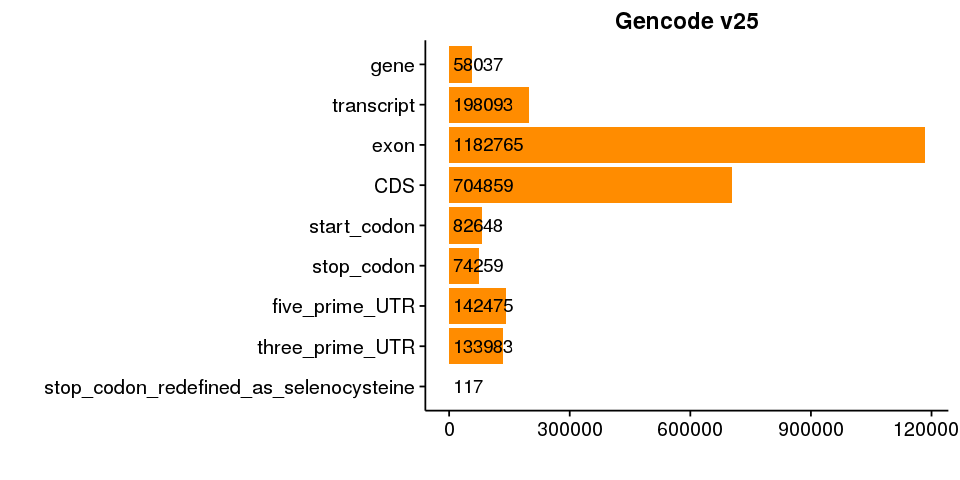

In [32]:
fig1 <- ggplot(gencode, aes(x = factor(type, levels = rev(unique(type))))) +
    geom_bar(fill = "darkorange") +
    # affichons l’effectif sur chaque bar, avec le mot magique de ggplot2 ..count..
    geom_text(aes(label = ..count..), y = 10000, hjust = 0, stat = "count") +
    labs(x = "", y = "", title = "Gencode v25") +
    # renversons les axes
    coord_flip()

options(repr.plot.width=8, repr.plot.height=4)
fig1

In [33]:
ptm.begin <- proc.time()

   user  system elapsed 
  0.536   0.004   0.540 

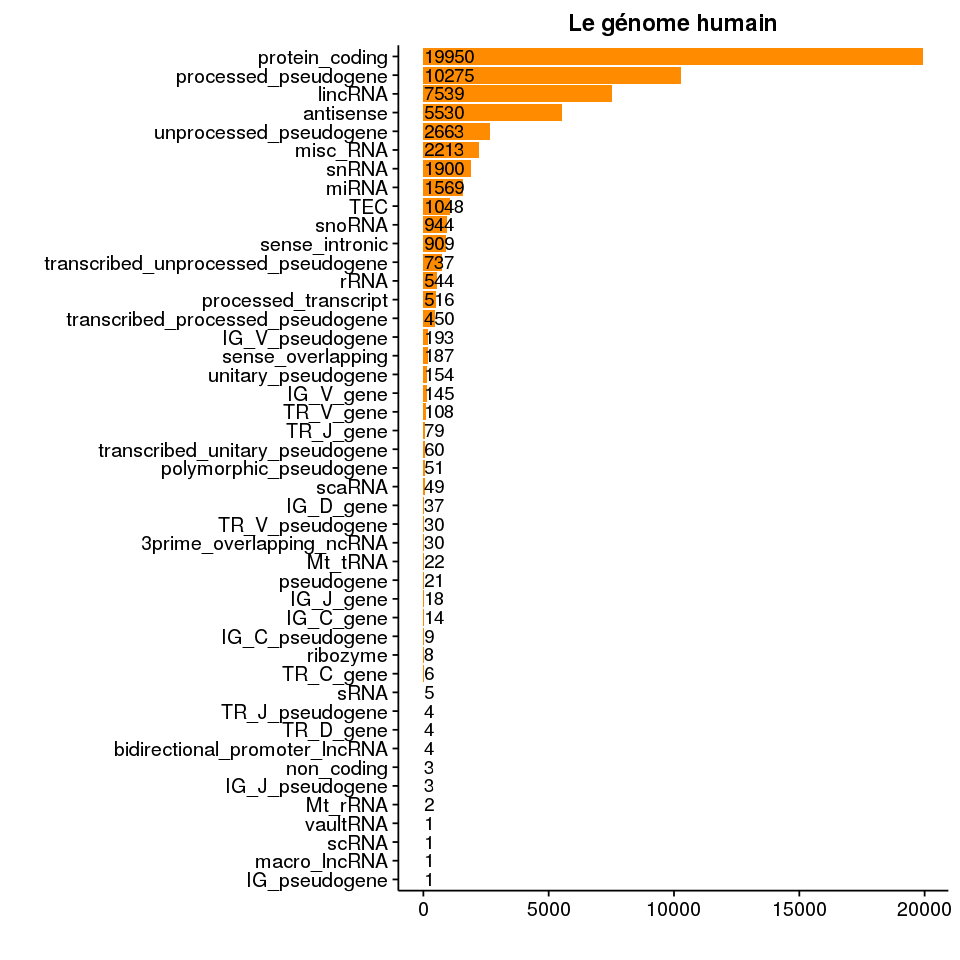

In [34]:
ptm <- proc.time()

fig2 <- filter(gencode, type == "gene") %>%
    # trions les types de gènes en fonction de leur effectif
    ggplot(aes(x = factor(
        gene_type,
        levels = names(sort(table(gene_type)))
    ))) +
    geom_bar(stat = "count", fill = "darkorange") +
    geom_text(aes(label = ..count..), y = 10, hjust = 0, stat = "count") +
    labs(x = "", y = "", title = "Le génome humain") +
    coord_flip()

options(repr.plot.width=8, repr.plot.height=8)
fig2


proc.time() - ptm 

In [35]:
ptm <- proc.time()

gencode$simple_gene_type <- gencode$gene_type
# si il y a pseudogene dans le nom, c'est un pseudogène
gencode$simple_gene_type[grepl("pseudogene", gencode$simple_gene_type)] <- "pseudogène"
# si il y a ARN dans le nom,  c'est un gène ARN
gencode$simple_gene_type[grepl("RNA", gencode$simple_gene_type)] <- "gène ARN"
# si c'est un autre type de gène, c'est un autre type de gène
gencode$simple_gene_type[!(gencode$simple_gene_type %in% c("protein_coding", "pseudogène", "gène ARN"))] <- "autre"
# en Français, c'est plus jolie
gencode$simple_gene_type[gencode$simple_gene_type == "protein_coding"] <- "gène protéique"
# trions par effectif, ça simplifiera le code des figures
gencode <- mutate(gencode, simple_gene_type = factor(
    simple_gene_type,
    levels = names(sort(table(simple_gene_type), decreasing = TRUE))
))
proc.time() - ptm 

   user  system elapsed 
  4.728   0.012   4.743 

   user  system elapsed 
  0.404   0.000   0.403 

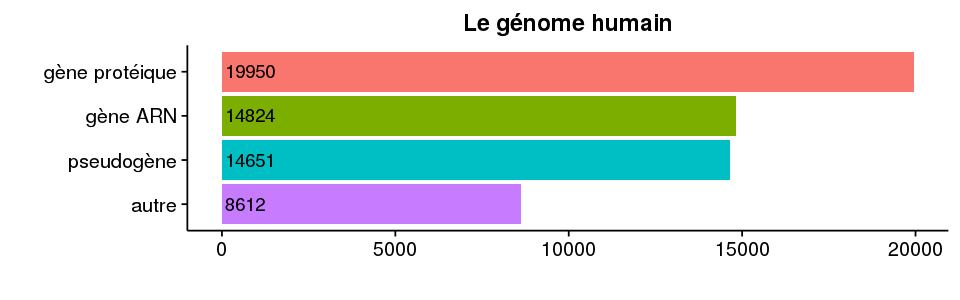

In [36]:
ptm <- proc.time()

fig3 <- filter(gencode, type == "gene") %>%
    ggplot(aes(x = factor(simple_gene_type, levels = rev(levels(simple_gene_type))), fill = simple_gene_type)) +
    geom_bar(stat = "count") +
    geom_text(aes(label = ..count..), y = 100, hjust = 0, stat = "count") +
    labs(x = "", y = "", title = "Le génome humain") +
    coord_flip() +
    theme(legend.position="none")

options(repr.plot.width=8, repr.plot.height=2.5)
fig3

proc.time() - ptm 

   user  system elapsed 
  0.392   0.000   0.392 

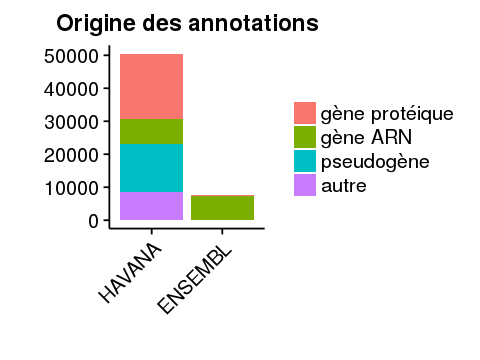

In [37]:
ptm <- proc.time()
fig4 <- filter(gencode, type == "gene") %>%
    ggplot(aes(x = source, fill = simple_gene_type)) +
    geom_bar(stat = "count") +
    labs(x = "", y = "", title = "Origine des annotations", fill = "") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

options(repr.plot.width=4, repr.plot.height=3)
fig4
proc.time() - ptm 

In [38]:
ptm <- proc.time()

# création d'une table contenant le nombre de gène par chromosome, pour chaque type simplifié de gène
genes_by_chr <- filter(gencode, type == "gene") %>%
    # table() compte les effectifs pour chaque combinaison
    with(., table(simple_gene_type, seqnames)) %>%
    # tidy() transforme l’affreux objet retourné par table() en un joli tableau
    tidy
 
fig5A <- ggplot(genes_by_chr, aes(x = seqnames, y = Freq, fill = simple_gene_type)) +
    # pour une fois, on ne veut pas stat = "count"
    geom_bar(stat = "identity") +
    labs(x = "", y = "", title = "Gènes par chromosomes") +
    theme(legend.position = "none", axis.text.x = element_text(angle = 90, hjust = 0, vjust = 0.5))

proc.time() - ptm  

   user  system elapsed 
  0.112   0.000   0.110 

In [39]:
ptm <- proc.time()

# lecture du fichier texte directement depuis le serveur
chr_length <- read_tsv("http://hgdownload-test.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes", col_names = FALSE) %>%
    # on nome les colonnes
    dplyr::rename(seqnames = X1, length = X2) %>%
    # on ne guarde que les chromosomes standards
    filter(seqnames %in% c(paste0("chr", 1:22), "chrX", "chrY", "chrM")) %>%
    # que l'on ordonne
    mutate(seqnames = factor(seqnames, levels = c(paste0("chr", 1:22), "chrX", "chrY", "chrM")))
 
fig5B <- ggplot(chr_length, aes(x = seqnames, y = length)) +
    geom_bar(stat = "identity", fill = "darkorange") +
    labs(x = "", y = "", title = "Taille des chromosomes (pb)") +
    theme(axis.text.x = element_text(angle = 90, hjust = 0, vjust = 0.5))

proc.time() - ptm 

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_integer()
)


   user  system elapsed 
  0.208   0.152   0.360 

In [40]:
ptm <- proc.time()

# fusion des deux tableau grâce a dplyr::left_join
genes_by_chr <- left_join(genes_by_chr, chr_length, by = "seqnames") %>%
    # création d'une nouvelle colonne: le nombre de gènes par mégabase
    mutate(perMb = Freq * 1E6 / length)
 
fig5C <- ggplot(genes_by_chr, aes(x = seqnames, y = perMb, fill = simple_gene_type)) +
    geom_bar(stat = "identity") +
    coord_cartesian(ylim = c(0, 25)) +
    # une facette par type de gènes
    facet_wrap(~simple_gene_type, ncol = 1) +
    labs(x = "", y = "", title = "Gènes par mégabase par chromosomes") +
    theme(legend.position = "none", axis.text.x = element_text(angle = 90, hjust = 0, vjust = 0.5))

proc.time() - ptm  

   user  system elapsed 
  0.012   0.000   0.012 

   user  system elapsed 
  1.272   0.000   1.273 

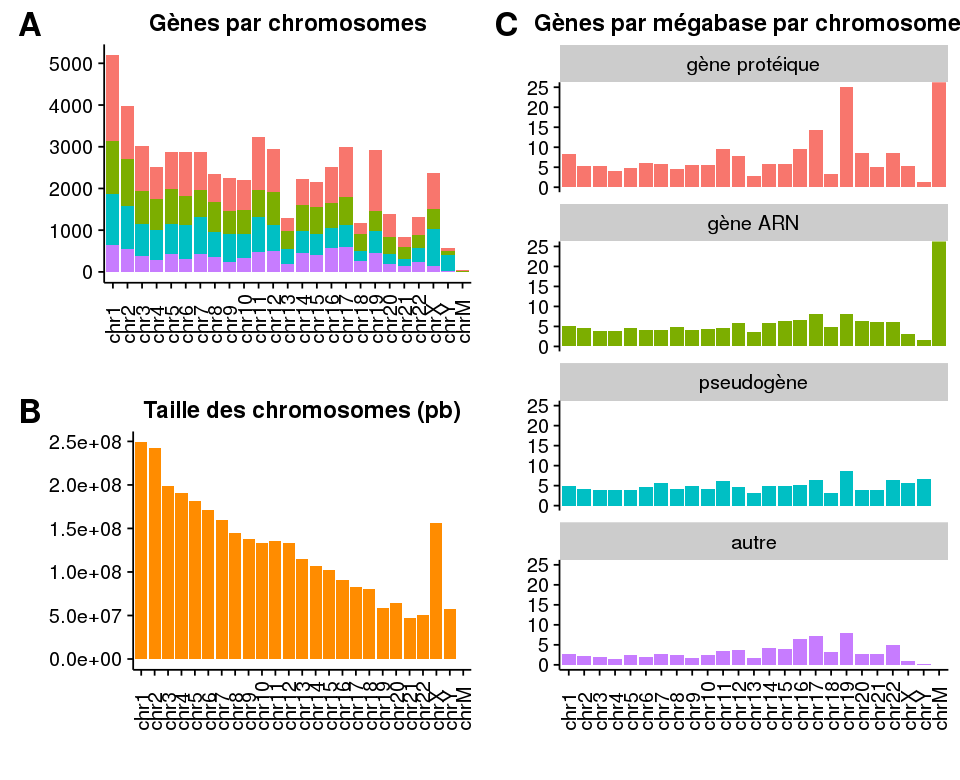

In [41]:
ptm <- proc.time()

# assemblage des panneaux avec cowplot
# la zone fait 1 x 1, avec le point (0,0) en bas à gauche
fig5 <- ggdraw() +
    draw_plot(fig5A, x = 0  , y = 0.5, w = 0.5, h = 0.5) +
    draw_plot(fig5B, x = 0  , y = 0  , w = 0.5, h = 0.5) +
    draw_plot(fig5C, x = 0.5, y = 0  , w = 0.5, h = 1  ) +
    draw_plot_label(c("A", "B", "C"), c(0, 0, 0.5), c(1, 0.5, 1), size = 20)

options(repr.plot.width=8, repr.plot.height=6.5)
fig5

proc.time() - ptm 

In [42]:
ptm <- proc.time()

fig6A <- filter(gencode, type == "transcript") %>%
    # group_by groupe le tableau de donnée en fonction de colonnes particuliéres
    # les fonction dplyr appelées aprés un group_by s'appliquent individuellement pour chaque groupe
    group_by(gene_id, simple_gene_type) %>%
    # en l'occurence, pour chaque gène, on demande le nombre de transcrit via la fonction n()
    summarise(n_transcript = n()) %>%
    # pour rendre le plot plus lisible, la valeur maximale sera 20 transcrits
    mutate(n_transcript = if_else(n_transcript > 20, 20L, n_transcript)) %>%
    ggplot(aes(x = n_transcript, fill = simple_gene_type)) +
    geom_bar() +
    scale_x_continuous(breaks = c(1, 10, 20), labels = c(1, 10, "\u2265 20")) +
    facet_wrap(~simple_gene_type, scales = "free_y", ncol = 1) +
    theme(legend.position = "none") +
    labs(x = "Nombre de\ntranscrits", y = "Nombre de gènes", title = "Transcrits\npar gènes")

proc.time() - ptm 

   user  system elapsed 
 11.368   0.000  11.376 

In [43]:
ptm <- proc.time()
fig6B <- filter(gencode, type == "exon") %>%
    mutate(exon_number = as.integer(exon_number)) %>%
    group_by(gene_id, simple_gene_type) %>%
    # cette fois, le nombre d'exon d'un gènes et définie comme le maximum du numéro d'exon de ce gène
    summarise(n_exon = max(exon_number)) %>%
    mutate(n_exon = if_else(n_exon > 20, 20L, n_exon)) %>%
    ggplot(aes(x = n_exon, fill = simple_gene_type)) +
    geom_bar() +
    scale_x_continuous(breaks = c(1, 10, 20), labels = c(1, 10, "\u2265 20")) +
    facet_wrap(~simple_gene_type, scales = "free_y", ncol = 1) +
    theme(legend.position = "none") +
    labs(x = "Nombre\nd'exons", y = "Nombre de gènes", title = "Exons\npar gènes")

proc.time() - ptm 

   user  system elapsed 
 11.872   0.000  11.884 

In [44]:
ptm <- proc.time()

fig6C <- filter(gencode, type == "gene") %>%
    mutate(
        # on extrait le numéro de version de l'annotation de chaque gène
        gene_version = strsplit(gene_id, ".", fixed = TRUE) %>%
            sapply(last) %>%
            as.integer()
    ) %>%
    mutate(gene_version = if_else(gene_version > 20, 20L, gene_version)) %>%
    ggplot(aes(x = gene_version, fill = simple_gene_type)) +
    geom_bar() +
    scale_x_continuous(breaks = c(1, 10, 20), labels = c(1, 10, "\u2265 20")) +
    facet_wrap(~simple_gene_type, scales = "free_y", ncol = 1) +
    theme(legend.position = "none") +
    labs(x = "Nombre de\nrévisions", y = "Nombre de gènes", title = "Révisions\npar gènes")

proc.time() - ptm 

   user  system elapsed 
  1.648   0.000   1.650 

In [45]:
# plot_grid est une version simplifié de ggdraw(), dans lequel les plots sont rangés dans une grille
fig6 <- plot_grid(fig6A, fig6B, fig6C, labels = LETTERS[1:3], ncol = 3, label_size = 20)

Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“erreur de conversion de '≥ 20' dans 'mbcsToSbcs' : le point est substitué pour <e2>”Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“erreur de conversion de '≥ 20' dans 'mbcsToSbcs' : le point est substitué pour <89>”Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“erreur de conversion de '≥ 20' dans 'mbcsToSbcs' : le point est substitué pour <a5>”Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“erreur de conversion de '≥ 20' dans 'mbcsToSbcs' : le point est substitué pour <e2>”Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“erreur de conversion de '≥ 20' dans 'mbcsToSbcs' : le point est substitué pour <89>”Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“erreur de conversion de '≥ 20' dans 'mbcsToSbcs' : le point est substitué pour <a5

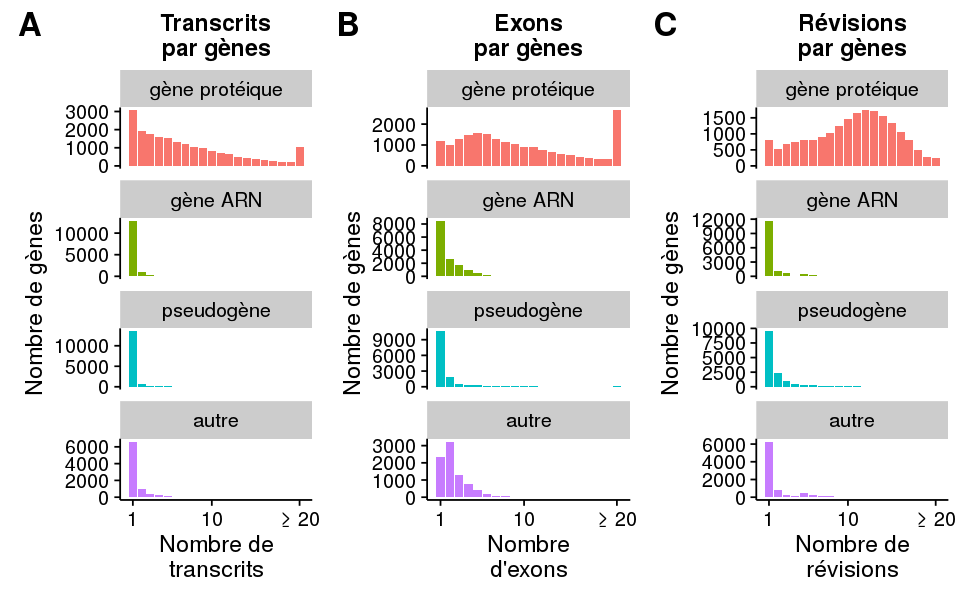

In [46]:
options(repr.plot.width=8, repr.plot.height=5)
fig6

In [47]:
ptm <- proc.time()

# la longueur exons + introns est triviale à obtenir grâce à la colonne width
fig7A <- filter(gencode, type == "gene") %>%
    ggplot(aes(x = width, fill = simple_gene_type, color = simple_gene_type)) +
    # geom_denisty plot la distribution des longueurs
    geom_density(alpha = 0.2) +
    # on fixe la même échelle pour tout les plots
    scale_x_log10(limits = c(10, 10000000)) +
    annotation_logticks(sides = "b") +
    labs(x = "Paire de bases", y = "Densité", title = "Longueur des gènes (exons + introns)", fill = "", color = "")

proc.time() - ptm  

   user  system elapsed 
  0.104   0.000   0.103 

In [48]:
ptm <- proc.time()

# pour la longueur des transcrits, on somme tout les exons de chaque transcrits
fig7B <- filter(gencode, type == "exon") %>%
    # on groupe par transcrits
    group_by(gene_id, transcript_id, simple_gene_type) %>%
    summarise(transcript_length = sum(width)) %>%
    # puis par gènes
    group_by(gene_id, simple_gene_type) %>%
    # et on prend la longueur du transcrit médian
    summarise(gene_length = median(transcript_length)) %>%
    ggplot(aes(x = gene_length, fill = simple_gene_type, color = simple_gene_type)) +
    geom_density(alpha = 0.2) +
    scale_x_log10(limits = c(10, 10000000)) +
    annotation_logticks(sides = "b") +
    labs(x = "Paire de bases", y = "Densité", title = "Longueur des gènes (exons seuls)", fill = "", color = "")

proc.time() - ptm 

   user  system elapsed 
 25.536   0.008  25.567 

In [49]:
ptm <- proc.time()

# la longueur des exons est triviale à obtenir
fig7C <- filter(gencode, type == "exon") %>%
    ggplot(aes(x = width, fill = simple_gene_type, color = simple_gene_type)) +
    geom_density(alpha = 0.2) +
    scale_x_log10(limits = c(10, 10000000)) +
    annotation_logticks(sides = "b") +
    labs(x = "Paire de bases", y = "Densité", title = "Longueur des exons", fill = "", color = "")

proc.time() - ptm 

   user  system elapsed 
  0.364   0.000   0.364 

In [50]:
ptm <- proc.time()

# pour la longueur des introns, il faut ruser !
fig7D <- filter(gencode, type == "exon") %>%
    # on groupe par transcrit
    group_by(gene_id, transcript_id, simple_gene_type) %>%
    # pour chaque transcrit, on trie bien chaque exons dans l'ordre
    arrange(start) %>%
    # nouvelle colonne qui contient le start de la ligne du dessous, cad de l'exon suivant,
    # via la fonction lead().
    # puis, dans le même mutate, nouvelle colonne qui contient la différence entre la fin
    # d'un exon, et le début de l'exon suivant.
    mutate(next_exon_start = lead(start), intron_length =  next_exon_start - end) %>%
    ggplot(aes(x = intron_length, fill = simple_gene_type, color = simple_gene_type)) +
    geom_density(alpha = 0.2) +
    scale_x_log10(limits = c(10, 10000000)) +
    annotation_logticks(sides = "b") +
    labs(x = "Paire de bases", y = "Densité", title = "Longueur des introns", fill = "", color = "")

proc.time() - ptm  

   user  system elapsed 
 44.968   0.148  45.162 

In [51]:
fig7 <- plot_grid(fig7A, fig7B, fig7C, fig7D, labels = LETTERS[1:4], ncol = 1, label_size = 20)

Warning message:
“Removed 2 rows containing non-finite values (stat_density).”Warning message:
“Removed 2 rows containing non-finite values (stat_density).”Warning message:
“Removed 2141 rows containing non-finite values (stat_density).”Warning message in self$trans$transform(x):
“production de NaN”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 199480 rows containing non-finite values (stat_density).”

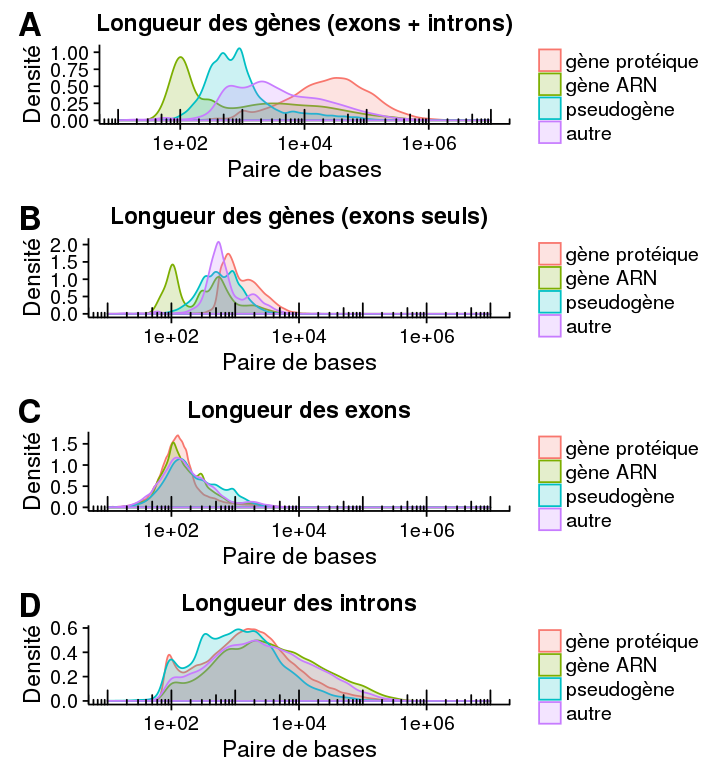

In [52]:
options(repr.plot.width=6, repr.plot.height=6.5)
fig7

In [53]:
ptm <- proc.time()

# A ce stade de l'article, vous devriez commencer à saisir la démarche:
# on ne garde que les lignes de type "CDS"
fig8A <- filter(gencode, type == "CDS") %>%
    # nouvelle colonne contenant le modulo 3
    mutate(modulo_3 = width %% 3) %>%
    ggplot(aes(x = modulo_3)) +
    geom_bar(fill = "darkorange") +
    labs(x = "", y = "effectif", title = "Modulo 3 des\nCDS (exons)")

proc.time() - ptm 

   user  system elapsed 
  0.248   0.088   0.333 

In [54]:
ptm <- proc.time()

fig8B <- filter(gencode, type == "CDS") %>%
    # on groupe par transcrit
    group_by(gene_id, transcript_id) %>%
    # on somme la taille de chaque CDS pour chaque transcrit
    summarise(total_CDS = sum(width)) %>%
    mutate(modulo_3 = total_CDS %% 3) %>%
    group_by(gene_id) %>%
    # pour chaque gène, on prends la mediane des modulos 3 des transcrits
    # qu'on arrondit au plus bas en cas de chiffre non entier
    summarise(modulo_3 = floor(median(modulo_3))) %>%
    ggplot(aes(x = modulo_3)) +
    geom_bar(fill = "darkorange") +
    labs(x = "", y = "effectif", title = "Modulo 3 des\nCDS (gènes)")

proc.time() - ptm 

   user  system elapsed 
 11.652   0.028  11.693 

In [55]:
fig8 <- plot_grid(fig8A, fig8B, labels = LETTERS[1:2], ncol = 2, label_size = 20)

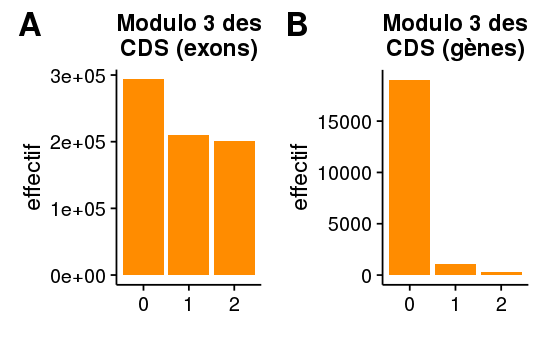

In [56]:
options(repr.plot.width=4.5, repr.plot.height=3)
fig8

   user  system elapsed 
  0.864   0.000   0.865 

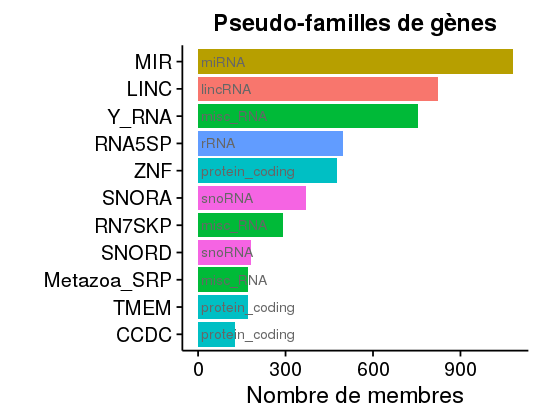

In [57]:
ptm <- proc.time()

fig9 <-  filter(gencode, type == "gene") %>%
    # on enléve les chiffres à la fin
    mutate(family_name = sub("[0-9]*$", "", gene_name)) %>%
    # on compte
    count(family_name, gene_type = gene_type) %>%
    # on ungroup avant de trier
    ungroup %>%
    arrange(desc(n)) %>%
    # on ne guarde que les familles de plus de 100 membres
    filter(n >= 100) %>%
    ggplot(aes(x = factor(family_name, levels = rev(family_name)), y = n, fill = gene_type)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label = gene_type, y = 10), hjust = 0, color = "grey40", size = 3) +
    coord_flip() +
    labs(x = "", y = "Nombre de membres", title = "Pseudo-familles de gènes") +
    theme(legend.position = "none")

options(repr.plot.width=4.5, repr.plot.height=3.5)
fig9

proc.time() - ptm 

In [58]:
proc.time() - ptm.begin

   user  system elapsed 
133.756   0.720 134.599 